# Segunda parte del Primer parcial DCGan Normal

Aqui se implemento un DCGan para generacion de imagenes

In [1]:
import torch
import torchvision
import numpy as np
from torch.utils.data.dataloader import DataLoader
import random
import matplotlib.pyplot as plt
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

classes = ("t-shirt", "trousers", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot")

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
        self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        return self.imgs[index], self.labels[index]

In [4]:
train = Dataset(trainset=trainset)
len(train)

C:\Users\Animetx\AppData\Local\Temp\ipykernel_15716\3310670369.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)


60000

In [5]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

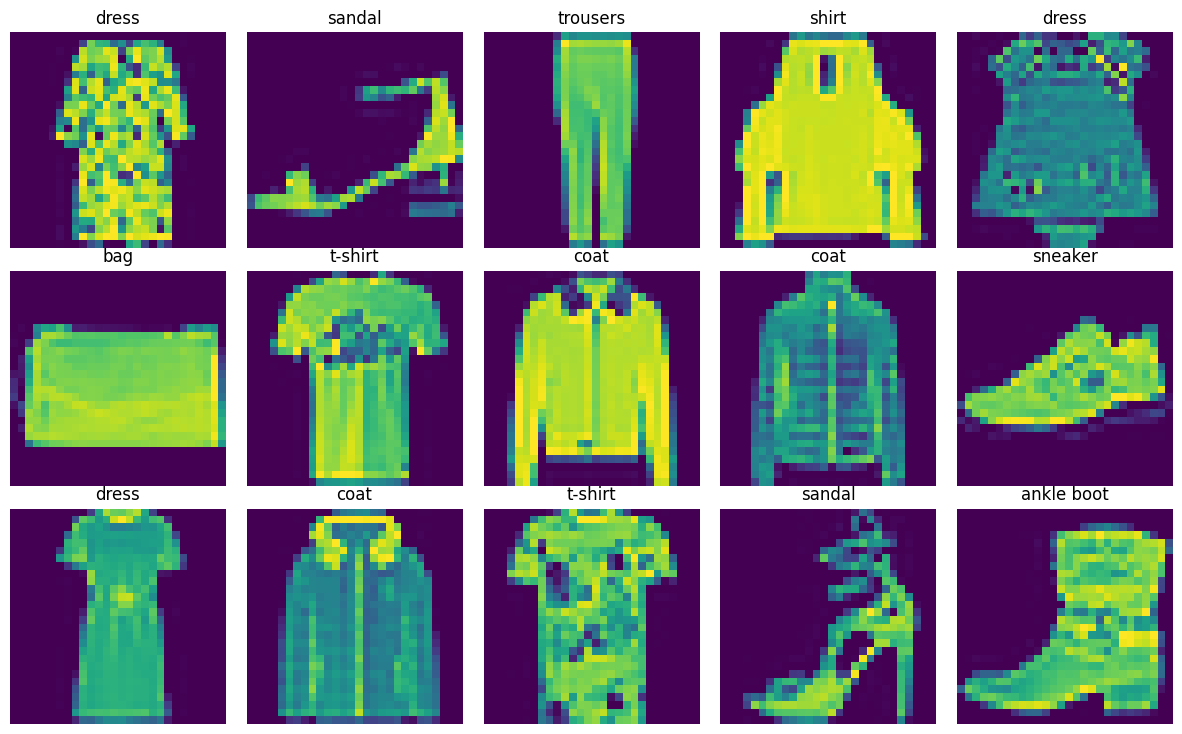

In [6]:
r, c, = 3,5

plt.figure(figsize=(c*3, r*3))

for row in range(r):
    for col in range(c):
        index = c*row + col;
        plt.subplot(r,c, index +1);
        ix = random.randint(0, len(train)-1);
        img, label = train[ix];
        plt.imshow(img.reshape(28,28).cpu());
        plt.axis('off')
        plt.title(classes[label.item()])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [7]:
def block(n_in, n_out):
    return nn.Sequential(
        nn.Linear(n_in, n_out),
        nn.ReLU(inplace=True)
    )

In [8]:
import math

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = n_embd // n_heads #d_k es la dimensión por cabeza
        
        assert n_embd % n_heads == 0, "n_embd must be divisible by n_heads"
        
        # QKV combinado
        self.qkv = nn.Linear(n_embd, 3 * n_embd)  # Solo 1 capa lineal
        self.proj = nn.Linear(n_embd, n_embd)
        
        
        # Escalamiento para estabilizar los gradientes
        self.scale = 1.0 / math.sqrt(self.head_dim)

    def forward(self, x):
        B, L, C = x.size()
        
        # QKV combinado - mucho más eficiente
        
        #Estructura: [batch, seq_len, QKV, num_heads, head_dim]
        #[QKV, batch, num_heads, seq_len, head_dim]
        qkv = self.qkv(x).reshape(B, L, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        
        #acceso a Q, K, V
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, nh, L, hd)
        
        # Atención escalada
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        
        # Aplicar atención
        y = attn @ v  # (B, nh, L, hd)
        y = y.transpose(1, 2).reshape(B, L, C)  # Reensamblar
        
        return self.proj(y)


In [9]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4 * n_embd),
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        x_attn = self.attn(x)
        x = self.ln1(x + x_attn)
        
        x_mlp = self.mlp(x)
        x = self.ln2(x + x_mlp)

        return x

In [10]:
class Generator(nn.Module):
    def __init__(self, n_input=7*7, n_embd = 7*7, seq_len= 16*16, n_heads=4*4, n_layers = 1, num_classes=10):
        super().__init__()
        self.input_size = 100
        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 7*7*128),
            nn.BatchNorm1d(7*7*128),
        )
        
        # self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, n_embd))
        # self.inp_embedding = nn.Linear(n_input, n_embd)
        #capas transformer
        # self.transformer_blocks = nn.Sequential(
        #     *[TransformerBlock(n_embd, n_heads) for _ in range(n_layers)]
        # )
        
        self.main = nn.Sequential(
            # *[TransformerBlock(n_embd, n_heads) for _ in range(n_layers)],
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 128, 7, 7)
        x = self.main(x)
        x = x.view(x.size(0), 28*28)
        return x

In [11]:
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 784])

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
        self.imgs = self.imgs * 2. - 1.
        self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        return self.imgs[ix], self.labels[ix]

    train = Dataset(trainset)
    len(train)

In [13]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=30, crit=None):
  g.to(device)
  d.to(device)
  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
  crit = nn.BCEWithLogitsLoss() if crit == None else crit
  g_loss, d_loss = [], []
  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:

    for X, y in progress_bar(dataloader, parent=mb):
      # X, y = X.to(device), y.to(device)
      # entrenamos el discriminador
      g.eval()
      d.train()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   input del discrminator
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
      #   ground truth para el discriminator
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
      #   optimización
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())
      # entrenamos el generador
      g.train()
      d.eval()
      #   generamos un batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)
      #   salidas del discriminador
      d_output = d(genenerated_images)
      #   gorund truth para el generator
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
      #   optimización
      g_optimizer.zero_grad()
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())
      # logs
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))
    hist['d_loss'].append(np.mean(d_loss))
  return hist

In [14]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]),
 torch.float32,
 tensor(1., device='cuda:0'),
 tensor(0., device='cuda:0'))

In [15]:
dataloader = DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 784]), torch.Size([32]))

In [16]:
class Discrimininator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,128, 4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(128*7*7,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 1, 28,28)
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

In [17]:
hist = fit(generator, Discrimininator(), dataloader, epochs=30)

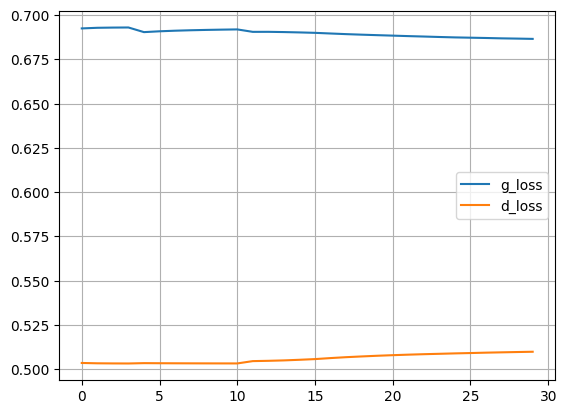

In [20]:
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

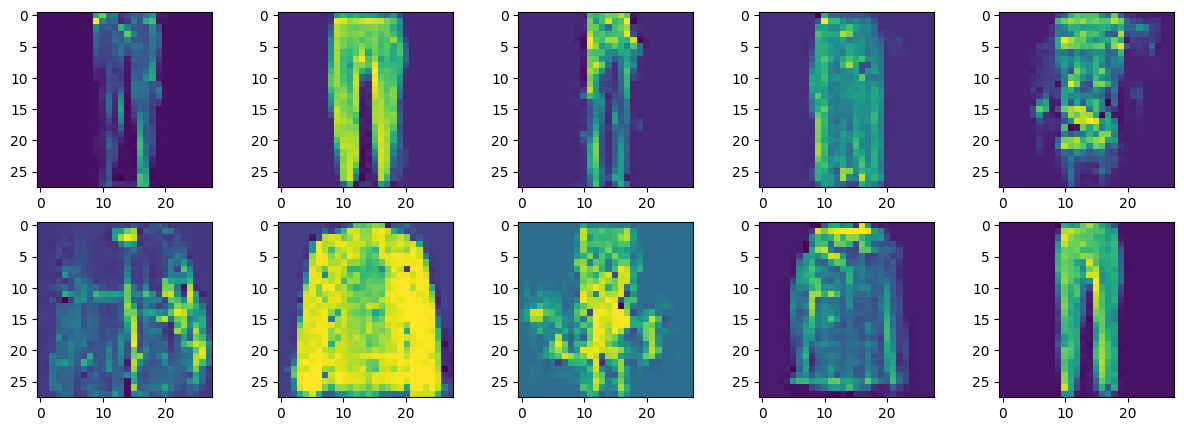

In [21]:
# generar imágenes aleatorias al final del entrenamiento

generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()